In [2]:
import random
import time
import io
import itertools
from pathlib import Path
from typing import Literal

import networkx as nx
import pandas as pd
import pygraphblas as gb
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

from project.shortest_paths import single_source_shortest_paths
from project.sssp_dynamic import DynamicSSSP
from project.sssp_dynamic import dijkstra_sssp

import sources directory


## Характеристики оборудования

========== OS  ==========

No LSB modules are available.
Distributor ID: Ubuntu
Description:    Ubuntu 20.04 LTS
Release:        20.04
Codename:       focal

========== CPU ==========

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   48 bits physical, 48 bits virtual
CPU(s):                          24
On-line CPU(s) list:             0-23
Thread(s) per core:              2
Core(s) per socket:              12
Socket(s):                       1
Vendor ID:                       AuthenticAMD
CPU family:                      25
Model:                           33
Model name:                      AMD Ryzen 9 5900X 12-Core Processor
Stepping:                        0
CPU MHz:                         3693.068
BogoMIPS:                        7386.13
Hypervisor vendor:               Microsoft
Virtualization type:             full
L1d cache:                       384 KiB
L1i cache:                       384 KiB
L2 cache:                        6 MiB
L3 cache:                        32 MiB
Vulnerability Itlb multihit:     Not affected
Vulnerability L1tf:              Not affected
Vulnerability Mds:               Not affected
Vulnerability Meltdown:          Not affected
Vulnerability Spec store bypass: Vulnerable
Vulnerability Spectre v1:        Mitigation; usercopy/swapgs barriers and __user pointer sanitization
Vulnerability Spectre v2:        Mitigation; Full AMD retpoline, IBPB conditional, IBRS_FW, STIBP conditional, RSB filli
                                 ng
Vulnerability Srbds:             Not affected
Vulnerability Tsx async abort:   Not affected
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxs
                                 r sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl t
                                 sc_reliable nonstop_tsc cpuid extd_apicid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 mo
                                 vbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a
                                  misalignsse 3dnowprefetch osvw topoext ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep
                                  bmi2 erms rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 xsaves clzero
                                  xsaveerptr arat umip vaes vpclmulqdq rdpid fsrm

========== GPU ==========

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-a66427f4-9cf7-11ed-a8fc-0242ac120002)
Thu Jan 25 22:17:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   54C    P0    54W / 200W |    323MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+

========== RAM ==========
              total        used        free      shared  buff/cache   available
Mem:          25578         199       24861           0         517       24978
Swap:          7168           0        7168

## Генерация графов

Графы для проведения эксперимента поделены на группы по колиеству вершин — до 100, 1000, 5000, 10000, 25000, 50000, 100000 вершин. В каждой категории находится по три графа

Графы генерировались с помощью библиотеки networkx. Все графы социальных сетей попадают в первую группу графов (<100) и взяты как готовые семплы networkx.

Для генерации графов остальных групп будет использован _nx.generators.community.random_partition_graph_. Для каждой из этих групп характерны фиксированные количества сообществ — 500, 200 и 50. К тому же, с помощью аргументов упомянутого метода настроено более частое появление ребер внутри сообществ, нежели чем между сообществами.

In [2]:
none_social_nodes_count = [1000, 5000, 10000, 25000, 50000, 100000]
nodes_count = [100, 1000, 5000, 10000, 25000, 50000, 100000]

samples = {c: [
    nx.generators.community.random_partition_graph([c // 500] * 500, min(3000 / (c * (i + 1)), 1.0), 2000 / (c * c * (i + 1)), directed=True),
    nx.generators.community.random_partition_graph([c // 200] * 200, 900 / (c * (i + 1)), 800 / (c * c * (i + 1)), directed=True),
    nx.generators.community.random_partition_graph([c // 50] * 50, 300 / (c * (i + 1)), 300 / (c * c * (i + 1)), directed=True),
] for i, c in enumerate(none_social_nodes_count)}

samples[100] = {
    nx.DiGraph(nx.generators.davis_southern_women_graph()),
    nx.DiGraph(nx.generators.florentine_families_graph()),
    nx.DiGraph(nx.generators.karate_club_graph()),
}

for g in itertools.chain(*samples.values()):
    print(g)

DiGraph named 'stochastic_block_model' with 1000 nodes and 2958 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 4395 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 6018 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 14491 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 11348 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 14925 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 19436 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 14840 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 19913 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 37232 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 28133 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 37621 edges
DiGraph named 'stochastic_block_model' with 50000 nodes and 59630 edges
DiGraph named 'stochastic_block_model' with 50000 nodes and 44738 edges
D

## Проведение замеров

Замеры времени работы производились для каждого графа, каждого алгоритма и каждого процента изменившихся рёбер. 

В случае динамического алгоритма замеряется только время запроса расстояний (инициализация не считается). В свою очередь, замеры для статических алгоритмов проводятся после внесения изменений.

Также не учитывается перевод графа в матрицу смежности для алгоритма Беллмана-Форда ввиду того, что представление данных в эксперименте не должно влиять на результаты замеров отдельного алгоритма.

In [4]:
results = Path("results.csv")

In [3]:
def select_edges(g: nx.DiGraph, edges_part: float):
    n = int(g.number_of_edges() * edges_part)
    return random.sample(list(g.edges), k=n)

def save_result(
        algo: Literal["Bellman-Ford", "Dijkstra", "Dynamic"],
        run_type: Literal["Inc", "Dec", "Mixed"],
        n_vertices: int,
        modified_edges_ratio: float,
        time_sec: float,
):
    res_str = f"{algo},{run_type},{n_vertices},{modified_edges_ratio},{time_sec}"
    with open(results, "a") as f:
        f.write(res_str + "\n")
    print(f"{res_str}")

def run_single_source_shortest_paths(graph: nx.DiGraph, source: int) -> float:
    matrix = gb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
    matrix.eadd(gb.Matrix.identity(gb.FP64, matrix.nrows, value=0), out=matrix)
    source_index = list(graph).index(source)

    start = time.perf_counter()
    single_source_shortest_paths(matrix, source_index)
    end = time.perf_counter()

    return end - start


def run_dijkstra_sssp(graph: nx.DiGraph, source: int) -> float:
    start = time.perf_counter()
    dijkstra_sssp(graph, source)
    end = time.perf_counter()
    return end - start

def inc_static(graph: nx.DiGraph, edges_to_add):
    temp_graph = nx.DiGraph()
    temp_graph.add_nodes_from(graph.nodes)
    source = random.sample(list(graph.nodes), 1)[0]

    for e in edges_to_add:
        temp_graph.add_edge(*e)

    time_sssp = run_single_source_shortest_paths(temp_graph, source)
    save_result("Bellman-Ford", "Inc", graph.number_of_nodes(), ratio, time_sssp)
    time_dijkstra_sssp = run_dijkstra_sssp(temp_graph, source)
    save_result("Dijkstra", "Inc", graph.number_of_nodes(), ratio, time_dijkstra_sssp)

def dec_static(graph: nx.DiGraph, edges_to_del):
    temp_graph = nx.DiGraph(graph)
    source = random.sample(list(graph.nodes), 1)[0]

    for e in edges_to_del:
        temp_graph.remove_edge(*e)

    time_sssp = run_single_source_shortest_paths(temp_graph, source)
    save_result("Bellman-Ford", "Dec", graph.number_of_nodes(), ratio, time_sssp)
    time_dijkstra_sssp = run_dijkstra_sssp(temp_graph, source)
    save_result("Dijkstra", "Dec", graph.number_of_nodes(), ratio, time_dijkstra_sssp)

def mix_static(graph: nx.DiGraph, edges_to_del):
    temp_graph = nx.DiGraph()
    temp_graph.add_nodes_from(graph.nodes)
    source = random.sample(list(graph.nodes), 1)[0]
    
    temp_graph.add_edges_from(graph.edges - edges_to_del)

    time_sssp = run_single_source_shortest_paths(temp_graph, source)
    save_result("Bellman-Ford", "Mixed", graph.number_of_nodes(), ratio, time_sssp)
    time_dijkstra_sssp = run_dijkstra_sssp(temp_graph, source)
    save_result("Dijkstra", "Mixed", graph.number_of_nodes(), ratio, time_dijkstra_sssp)

def inc_dynamic(graph: nx.DiGraph, edges_to_add):
    temp_graph = nx.DiGraph()
    temp_graph.add_nodes_from(graph.nodes)
    source = random.sample(list(graph.nodes), 1)[0]
    init = DynamicSSSP(temp_graph, source)

    for e in edges_to_add:
        init.add_edge(*e)

    start = time.perf_counter()
    init.get_dists()
    end = time.perf_counter()

    del init
    save_result("Dynamic", "Inc", graph.number_of_nodes(), ratio, end - start)

def dec_dynamic(graph: nx.DiGraph, edges_to_del):
    temp_graph = nx.DiGraph(graph)
    source = random.sample(list(graph.nodes), 1)[0]
    init = DynamicSSSP(temp_graph, source)

    for e in edges_to_del:
        init.remove_edge(*e)

    start = time.perf_counter()
    init.get_dists()
    end = time.perf_counter()

    del init
    save_result("Dynamic", "Dec", graph.number_of_nodes(), ratio, end - start)

def mix_dynamic(graph: nx.DiGraph, edges_to_add, edges_to_del):
    temp_graph = nx.DiGraph()
    temp_graph.add_nodes_from(graph.nodes)
    temp_graph.add_edges_from(graph.edges - edges_to_add)
    source = random.sample(list(graph.nodes), 1)[0]
    init = DynamicSSSP(temp_graph, source)

    for e_add, e_del in itertools.zip_longest(edges_to_add, edges_to_del):
        if e_add:
            init.add_edge(*e_add)
        if e_del:
            init.remove_edge(*e_del)

    start = time.perf_counter()
    init.get_dists()
    end = time.perf_counter()

    del init
    save_result("Dynamic", "Mixed", graph.number_of_nodes(), ratio, end - start)

for _, graph_list in samples.items():
    for g in graph_list:
        for ratio in [0.1, 0.2, 0.3, 0.4, 0.5]:
            print(f"Ratio: {ratio}")
            edges_to_modify = select_edges(g, ratio)
            edges_to_keep = g.edges - edges_to_modify
            inc_static(g, edges_to_keep)
            dec_static(g, edges_to_modify)
            inc_dynamic(g, edges_to_keep)
            dec_dynamic(g, edges_to_modify)

            edges_to_add = edges_to_modify[:len(edges_to_modify) // 2]
            edges_to_del = edges_to_modify[len(edges_to_modify) // 2:]

            mix_static(g, edges_to_del)
            mix_dynamic(g, edges_to_add, edges_to_del)

Ratio: 0.1
Bellman-Ford,Inc,1000,0.1,0.01344173200050136
Dijkstra,Inc,1000,0.1,0.0007423800016113091
Bellman-Ford,Dec,1000,0.1,0.013245325000752928
Dijkstra,Dec,1000,0.1,0.000827911000669701
Dynamic,Inc,1000,0.1,0.0008922199995140545
Dynamic,Dec,1000,0.1,0.0029794889996992424
Bellman-Ford,Mixed,1000,0.1,0.013793740999972215
Dijkstra,Mixed,1000,0.1,0.0007073039996612351
Dynamic,Mixed,1000,0.1,0.003958283003157703
Ratio: 0.2
Bellman-Ford,Inc,1000,0.2,0.012083138000889448
Dijkstra,Inc,1000,0.2,0.0006057339996914379
Bellman-Ford,Dec,1000,0.2,0.012195537998195505
Dijkstra,Dec,1000,0.2,0.0008503019998897798
Dynamic,Inc,1000,0.2,0.004546644999209093
Dynamic,Dec,1000,0.2,0.005942378000327153
Bellman-Ford,Mixed,1000,0.2,0.013266493999253726
Dijkstra,Mixed,1000,0.2,0.0007133059989428148
Dynamic,Mixed,1000,0.2,0.005227157998888288
Ratio: 0.3
Bellman-Ford,Inc,1000,0.3,0.011195053997653304
Dijkstra,Inc,1000,0.3,0.0005926400008320343
Bellman-Ford,Dec,1000,0.3,0.011349464002705645
Dijkstra,Dec,1000,0

Bellman-Ford,Dec,5000,0.1,0.02618651899683755
Dijkstra,Dec,5000,0.1,0.0004478490009205416
Dynamic,Inc,5000,0.1,0.0038768300000810996
Dynamic,Dec,5000,0.1,0.0010294879975845106
Bellman-Ford,Mixed,5000,0.1,0.16767512899969006
Dijkstra,Mixed,5000,0.1,0.0026541500010353047
Dynamic,Mixed,5000,0.1,0.0187707010009035
Ratio: 0.2
Bellman-Ford,Inc,5000,0.2,0.0623042439983692
Dijkstra,Inc,5000,0.2,0.0005930109982728027
Bellman-Ford,Dec,5000,0.2,0.028997181998420274
Dijkstra,Dec,5000,0.2,0.000480629998492077
Dynamic,Inc,5000,0.2,0.00418943600016064
Dynamic,Dec,5000,0.2,0.020226548000209732
Bellman-Ford,Mixed,5000,0.2,0.06748264199995901
Dijkstra,Mixed,5000,0.2,0.0007208099996205419
Dynamic,Mixed,5000,0.2,0.001739106999593787
Ratio: 0.3
Bellman-Ford,Inc,5000,0.3,0.03459479400044074
Dijkstra,Inc,5000,0.3,0.0005122590009705164
Bellman-Ford,Dec,5000,0.3,0.03310381200208212
Dijkstra,Dec,5000,0.3,0.00046486000064760447
Dynamic,Inc,5000,0.3,0.003660394999315031
Dynamic,Dec,5000,0.3,0.019256530998973176
B

Dynamic,Mixed,10000,0.5,0.004382056002214085
Ratio: 0.1
Bellman-Ford,Inc,10000,0.1,0.28314375300033134
Dijkstra,Inc,10000,0.1,0.0021819559988216497
Bellman-Ford,Dec,10000,0.1,0.25082915800157934
Dijkstra,Dec,10000,0.1,0.0019249750002927613
Dynamic,Inc,10000,0.1,0.008267681998404441
Dynamic,Dec,10000,0.1,0.021689176999643678
Bellman-Ford,Mixed,10000,0.1,0.30787109800075996
Dijkstra,Mixed,10000,0.1,0.0024668299993209075
Dynamic,Mixed,10000,0.1,0.004074951000802685
Ratio: 0.2
Bellman-Ford,Inc,10000,0.2,0.07341982100115274
Dijkstra,Inc,10000,0.2,0.0008992040020530112
Bellman-Ford,Dec,10000,0.2,0.04639943099755328
Dijkstra,Dec,10000,0.2,0.0007779769985063467
Dynamic,Inc,10000,0.2,0.00759194700003718
Dynamic,Dec,10000,0.2,0.014983117998781381
Bellman-Ford,Mixed,10000,0.2,0.3043484209993039
Dijkstra,Mixed,10000,0.2,0.0023768409992044326
Dynamic,Mixed,10000,0.2,0.01855000799696427
Ratio: 0.3
Bellman-Ford,Inc,10000,0.3,0.06756776200199965
Dijkstra,Inc,10000,0.3,0.000841215001855744
Bellman-Ford

Dynamic,Inc,25000,0.5,0.014432708001550054
Dynamic,Dec,25000,0.5,0.011630039000010584
Bellman-Ford,Mixed,25000,0.5,0.11904444000174408
Dijkstra,Mixed,25000,0.5,0.0021248089979053475
Dynamic,Mixed,25000,0.5,0.012673553002969129
Ratio: 0.1
Bellman-Ford,Inc,50000,0.1,0.23754334799741628
Dijkstra,Inc,50000,0.1,0.004406662999826949
Bellman-Ford,Dec,50000,0.1,0.295831833002012
Dijkstra,Dec,50000,0.1,0.004402664002554957
Dynamic,Inc,50000,0.1,0.03211593199739582
Dynamic,Dec,50000,0.1,0.005415089999587508
Bellman-Ford,Mixed,50000,0.1,0.2930808810015151
Dijkstra,Mixed,50000,0.1,0.004517891000432428
Dynamic,Mixed,50000,0.1,0.005688893001206452
Ratio: 0.2
Bellman-Ford,Inc,50000,0.2,0.2346778129976883
Dijkstra,Inc,50000,0.2,0.004281487999833189
Bellman-Ford,Dec,50000,0.2,0.2317909459998191
Dijkstra,Dec,50000,0.2,0.0044743689977622125
Dynamic,Inc,50000,0.2,0.03216371199960122
Dynamic,Dec,50000,0.2,0.01172136000241153
Bellman-Ford,Mixed,50000,0.2,0.234528222001245
Dijkstra,Mixed,50000,0.2,0.00438928

Bellman-Ford,Dec,100000,0.5,0.46688886499759974
Dijkstra,Dec,100000,0.5,0.009696148001239635
Dynamic,Inc,100000,0.5,0.04215952999948058
Dynamic,Dec,100000,0.5,0.04032777099928353
Bellman-Ford,Mixed,100000,0.5,0.4796894360006263
Dijkstra,Mixed,100000,0.5,0.009557858000334818
Dynamic,Mixed,100000,0.5,0.04273723300138954
Ratio: 0.1
Bellman-Ford,Inc,100000,0.1,0.4618689839990111
Dijkstra,Inc,100000,0.1,0.009183468002447626
Bellman-Ford,Dec,100000,0.1,0.4673632030026056
Dijkstra,Dec,100000,0.1,0.008776153998041991
Dynamic,Inc,100000,0.1,0.05550987099923077
Dynamic,Dec,100000,0.1,0.008792876000370597
Bellman-Ford,Mixed,100000,0.1,0.4825225919994409
Dijkstra,Mixed,100000,0.1,0.00975713200023165
Dynamic,Mixed,100000,0.1,0.010613084999931743
Ratio: 0.2
Bellman-Ford,Inc,100000,0.2,0.4910145139983797
Dijkstra,Inc,100000,0.2,0.009783940000488656
Bellman-Ford,Dec,100000,0.2,0.48782812699937494
Dijkstra,Dec,100000,0.2,0.009668175000115298
Dynamic,Inc,100000,0.2,0.05936336800004938
Dynamic,Dec,100000

In [5]:
r = pd.read_csv(results, names=["Algo", "Type", "Vertices count", "Modified edges ratio", "Time, s"])
r

,Algo,Type,Vertices count,Modified edges ratio,"Time, s"
0,Bellman-Ford,Inc,1000,0.1,0.005135
1,Dijkstra,Inc,1000,0.1,0.000107
2,Bellman-Ford,Dec,1000,0.1,0.012997
3,Dijkstra,Dec,1000,0.1,0.000678
4,Dynamic,Inc,1000,0.1,0.005094
...,...,...,...,...,...
940,Dynamic,Inc,32,0.5,0.000169
941,Dynamic,Dec,32,0.5,0.000087
942,Bellman-Ford,Mixed,32,0.5,0.000202
943,Dijkstra,Mixed,32,0.5,0.000034


/home/z/.local/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (138996450 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ValueError: min() arg is an empty sequence

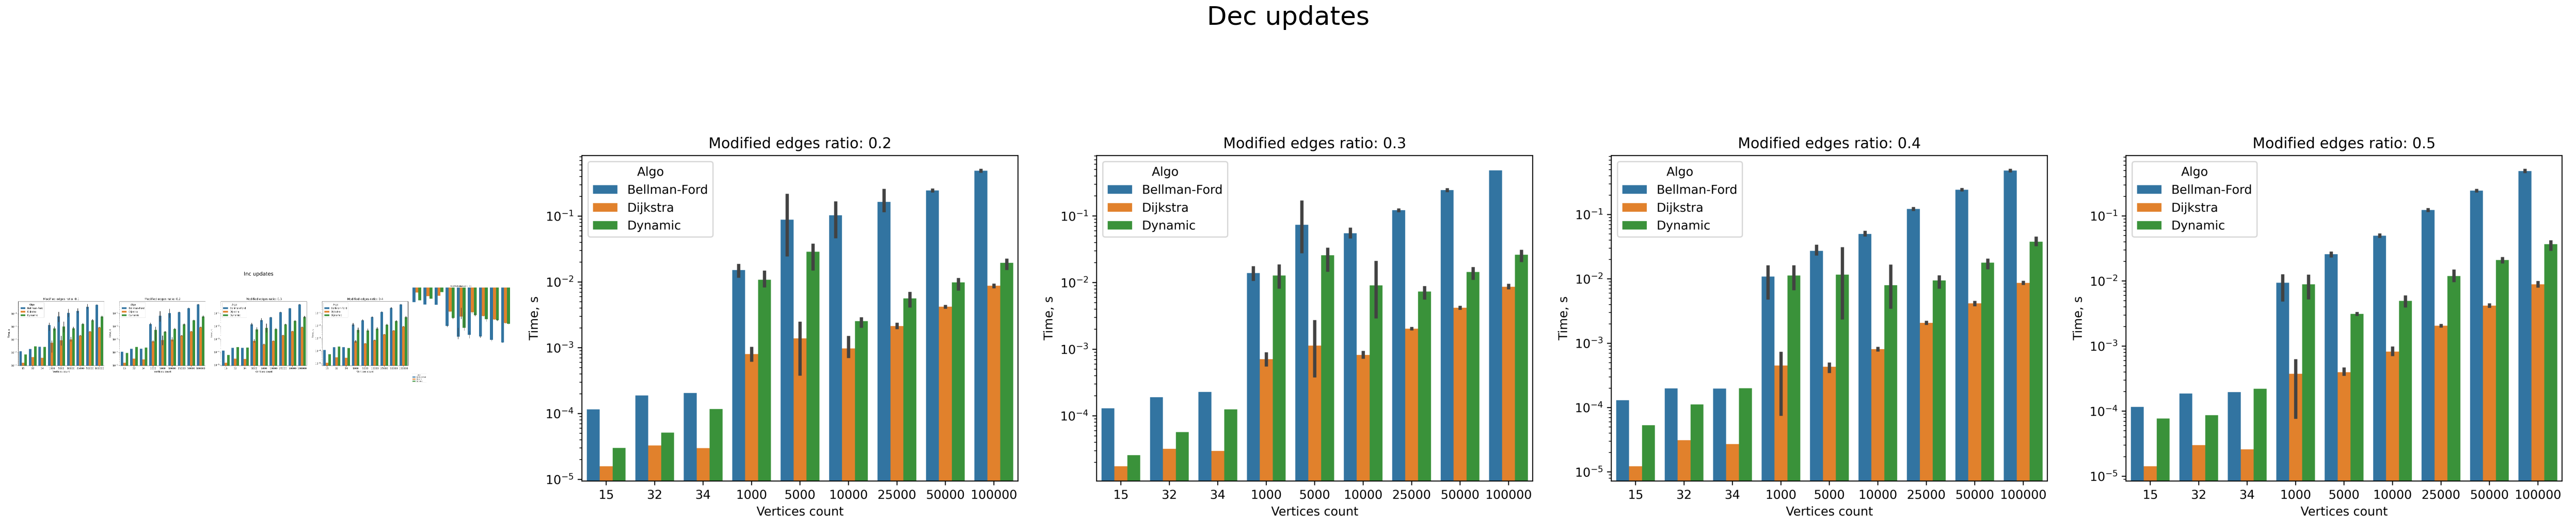

In [15]:
# A hacky way to show several catplots in a row, since they cannot be placed in subplots
def grid_to_image(grid: sns.FacetGrid) -> Image.Image:
    buf = io.BytesIO()
    grid.figure.savefig(buf, format="png", dpi=500, bbox_inches="tight")
    return Image.open(buf)


def show_detailed_plots():
    for updates_type in ["Inc", "Dec", "Mixed"]:
        plot_images = []
        for ratio in [0.1, 0.2, 0.3, 0.4, 0.5]:
            grid = sns.catplot(
                r[
                    (r["Type"] == updates_type[:3]) &
                    (r["Modified edges ratio"] == ratio)
                ],
                kind="bar",
                x="Vertices count",
                y="Time, s",
                hue="Algo",
                legend=ratio == 0.1,
                legend_out=False,
            )
            plt.title(f"Modified edges ratio: {ratio}")
            plt.yscale("log")

            if fraction != 0.1:
                grid.set_ylabels("")

            plot_images.append(grid_to_image(grid))
            plt.close()  # Removes the figure created by catplot

        fig, axs = plt.subplots(
            ncols=len([0.1, 0.2, 0.3, 0.4, 0.5]),
            figsize=(50, 25),
        )
        for ax, plot_image in zip(axs, plot_images):
            ax.imshow(plot_image)
            ax.axis("off")
        fig.tight_layout()

        fig.suptitle(f"{updates_type} updates", y=0.75, size=36)
        
show_detailed_plots()